In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import warnings
import os
warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore runtime warnings; here they arise from attempted operations on all-NaN arrays

In [2]:
years = [1991, 2020]
clim_years = [1991, 2020]
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'

In [3]:
f_ice=basepath+f'/OISST/oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
with xr.open_dataset(f_ice) as fice:
    icemask1=np.nanmax(fice.ice.data,axis=0)>0
    Amax=np.zeros((20,)+np.shape(icemask1))
    for ind in range(0,20):
        Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)
    AmaxH=np.mean(np.where(Amax>0,1,0),axis=0)

In [4]:
is_detrend=True
il=10

In [5]:
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
# Input/output directory
if is_detrend:
    dir = basepath+'/mhw/detrended';
    f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
    f_forMME = f'{dir}/mhw_MME_l{il}_detrended_{years[0]}_{years[1]}.nc'
else:
    dir = basepath+'/mhw';
    f_obs = basepath+f'/OISST/mhw_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
    f_forMME = f'{dir}/mhw_MME_l{il}_{years[0]}_{years[1]}.nc'

# Model names
#           1              2               3            4              5             6
mods = ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']#
nmod = len(mods)
nl = dict(zip(mods,[11, 11, 11, 11, 8, 9])) # Max lead time for each model


In [6]:
fforMME=xr.open_dataset(f_forMME)

In [7]:
fobs=xr.open_dataset(f_obs)

In [8]:
fobs

<xarray.Dataset> Size: 194MB
Dimensions:     (X: 360, Y: 181, S: 360, Mon: 12)
Coordinates:
  * X           (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y           (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * S           (S) float32 1kB 372.0 373.0 374.0 375.0 ... 729.0 730.0 731.0
  * Mon         (Mon) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lon         (X) float32 1kB ...
    lat         (Y) float32 724B ...
    time        (S) float32 1kB ...
    year        (S) int64 3kB ...
    month       (S) int64 3kB ...
    sst_an_thr  (Mon, Y, X) float64 6MB ...
    is_mhw      (S, Y, X) float64 188MB ...

In [9]:

# Loop through models
is_mhw_ens=[]
mlist=[]
flist=[]
for modi in mods:
    if il<nl[modi]:
        # Load MHWs
        if is_detrend:
            f_in = f'{dir}/mhw_{modi}_l{il}_detrended_{years[0]}_{years[1]}.nc'
        else:
            f_in = f'{dir}/mhw_{modi}_l{il}_{years[0]}_{years[1]}.nc'
            print(f_in)
        flist.append(f_in)
ffor=xr.open_mfdataset(flist,chunks={'X':10,'Y':10,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
                   coords='minimal',parallel=True,preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"]) )

In [10]:
ffor

<xarray.Dataset> Size: 8GB
Dimensions:  (X: 360, Y: 181, S: 360, M: 45, Mon: 12)
Coordinates:
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * M        (M) float32 180B 1.0 2.0 3.0 4.0 5.0 ... 11.0 12.0 13.0 14.0 15.0
  * S        (S) float32 1kB 372.0 373.0 374.0 375.0 ... 728.0 729.0 730.0 731.0
  * Mon      (Mon) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lon      (X) float32 1kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat      (Y) float32 724B dask.array<chunksize=(10,), meta=np.ndarray>
    time     (S) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
    year     (S) int64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    month    (S) int64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    is_mhw   (S, M, Y, X) float64 8GB dask.array<chunksize=(360, 10, 10, 10), meta=np.ndarray>

In [11]:
M=xr.where(np.isnan(ffor.is_mhw),0,1).sum(dim='M').mean(dim='S')

Ms=np.unique(M)
if len(Ms)>1: raise Exception('check M')
M=Ms[0]

In [12]:
mhwfor=ffor.is_mhw.data[:(-1*il),...]
mhwobs=fobs.is_mhw.data[il:,...]
N_pos=np.sum(mhwfor,axis=1).compute()
N_neg=np.sum((mhwfor==0).astype(float),axis=1).compute()
TP=np.where(mhwobs==1,N_pos,0)
TN=np.where(mhwobs==0,N_neg,0)
FP=np.where(mhwobs==0,N_pos,0)
FN=np.where(mhwobs==1,N_neg,0)

# calculate SEDI, summed over time
Nobs_pos=np.sum(mhwobs,axis=0)
Nobs_neg=np.sum(1-mhwobs,axis=0)
F=np.sum(FP,axis=0)/(Nobs_neg*M)
H=np.sum(TP,axis=0)/(Nobs_pos*M)

SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))

lmask=np.sum(fobs.is_mhw.data,axis=0)==0


if il<=8:
    M=73 # number of ensemble members
elif il<=9:
    M=73-4 # NASA-GEOSS2S drops out
else:
    M=73-4-24 # NCEP-CFSv2 drops out


mhwforMME=fforMME.mhw_prob.data[:(-1*il),...]
N_posMME=M*mhwforMME
N_negMME=M*(1-mhwforMME)



In [13]:
MMEprob2=ffor.is_mhw.data.mean(axis=1).compute()

In [14]:
MMEprob1=fforMME.mhw_prob.data

confirm equivalence between computation methods:

In [15]:
np.max(np.abs(MMEprob2-MMEprob1))

0.0

In [16]:
np.max(np.abs((N_pos-N_posMME)))

3.552713678800501e-15

In [17]:
lm=lmask
SEDI=np.ma.masked_where(AmaxH>0.5,SEDI)

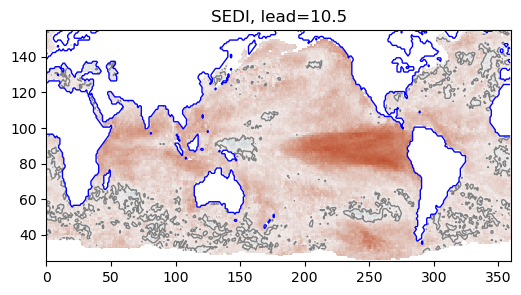

In [18]:
fig,ax=plt.subplots(1,1,figsize=(6,3))
m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

In [19]:
ffor.close()

In [20]:
def fSEDI(il):
    if is_detrend:
        f_save = f'{dir}/SEDI_MME_l{il}_detrended_{years[0]}_{years[1]}.nc'
    else:
        f_save = f'{dir}/SEDI_MME_l{il}_{years[0]}_{years[1]}.nc'
    return f_save

In [21]:
def calcSEDI_il(il,save=False):
    # Loop through models
    is_mhw_ens=[]
    mlist=[]
    flist=[]
    for modi in mods:
        if il<nl[modi]:
            # Load MHWs
            if is_detrend:
                f_in = f'{dir}/mhw_{modi}_l{il}_detrended_{years[0]}_{years[1]}.nc'
            else:
                f_in = f'{dir}/mhw_{modi}_l{il}_{years[0]}_{years[1]}.nc'
            flist.append(f_in)
    ffor=xr.open_mfdataset(flist,chunks={'X':10,'Y':10,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
                       coords='minimal',parallel=True,preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"]) )

    M=xr.where(np.isnan(ffor.is_mhw),0,1).sum(dim='M').mean(dim='S')
    
    Ms=np.unique(M)
    if len(Ms)>1: raise Exception('check M')
    M=Ms[0]
    mhwfor=ffor.is_mhw.data[:(-1*il),...]
    mhwobs=fobs.is_mhw.data[il:,...]
    N_pos=np.sum(mhwfor,axis=1).compute()
    N_neg=np.sum((mhwfor==0).astype(float),axis=1).compute()
    TP=np.where(mhwobs==1,N_pos,0)
    TN=np.where(mhwobs==0,N_neg,0)
    FP=np.where(mhwobs==0,N_pos,0)
    FN=np.where(mhwobs==1,N_neg,0)
    
    # calculate SEDI, summed over time
    Nobs_pos=np.sum(mhwobs,axis=0)
    Nobs_neg=np.sum(1-mhwobs,axis=0)
    F=np.sum(FP,axis=0)/(Nobs_neg*M)
    H=np.sum(TP,axis=0)/(Nobs_pos*M)
    
    SEDI=(np.log(F)-np.log(H)-np.log(1-F)+np.log(1-H))/(np.log(F)+np.log(H)+np.log(1-F)+np.log(1-H))
    lmask=np.sum(fobs.is_mhw.data,axis=0)==0
    icemask=AmaxH>0.5
    f_save=fSEDI(il)
    if save:
        xout=xr.Dataset(data_vars={'lon':(['X',],ffor.lon.values),
                    'lat':(['Y',],ffor.lat.values),
                    'SEDI':(['Y','X'],SEDI),
                    'lmask':(['Y','X'],lmask),
                    'icemask':(['Y','X'],icemask)},
                    coords=dict(X=ffor.X,Y=ffor.Y),)
        xout.to_netcdf(f_save,mode='w')
    ffor.close()
    return lmask,np.ma.masked_where(icemask,SEDI)

In [30]:
def get_SEDI(il,save=False):
    f_save=fSEDI(il)
    if os.path.exists(f_save):
        with xr.open_dataset(f_save) as ff:
            lm=np.array(ff.lmask.values)
            ice=np.array(ff.icemask.values)
            SEDI=np.array(ff.SEDI.values)
    else:
        lm,SEDI=calcSEDI_il(il,True)
    return lm,np.ma.masked_where(ice,SEDI)

### Reproduce Jacox et al (2022) Fig 1

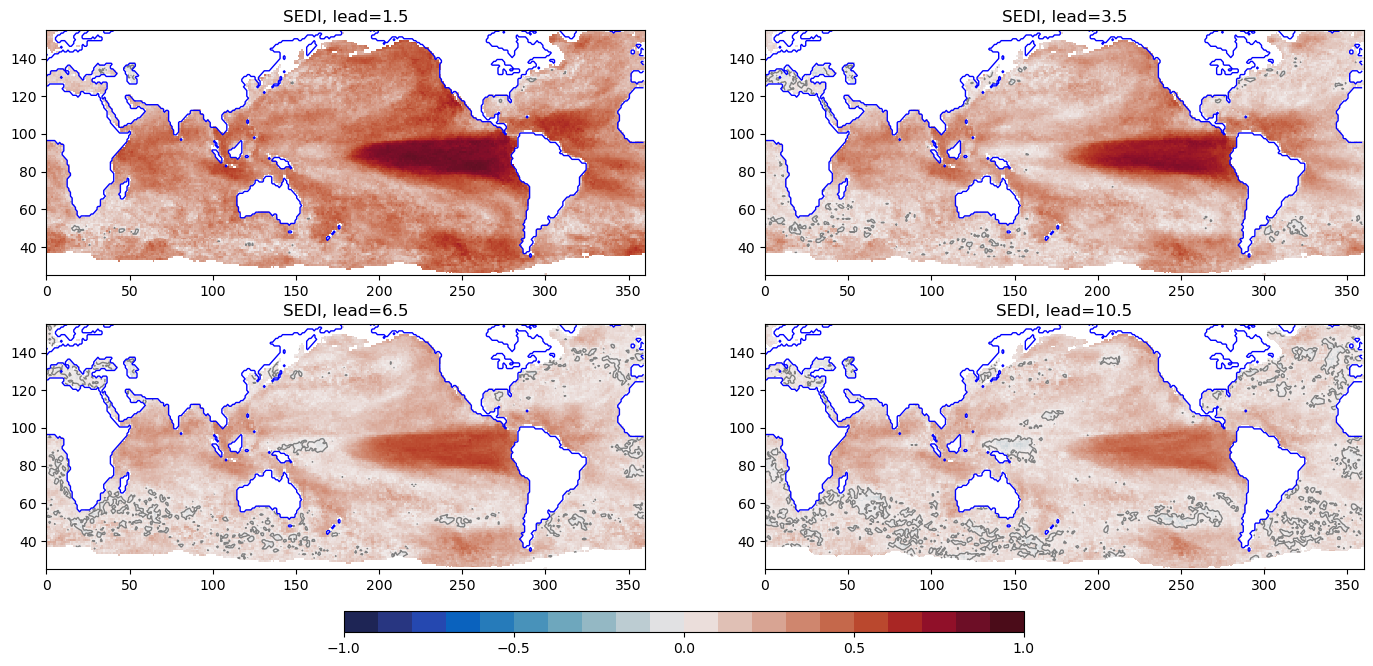

In [31]:
fig,axs=plt.subplots(2,2,figsize=(17,7),gridspec_kw={'hspace':.2})
ax=axs[0,0]; il=1
lm,SEDI=get_SEDI(il,True)
#m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ax=axs[0,1]; il=3
lm,SEDI=get_SEDI(il,True)
#m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ax=axs[1,0]; il=6
lm,SEDI=get_SEDI(il,True)
#m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ax=axs[1,1]; il=10
lm,SEDI=get_SEDI(il,True)
m=ax.contourf(SEDI,levels=np.arange(-1,1.1,.1),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m1=ax.pcolormesh(SEDI,vmin=-1,vmax=1,cmap=cmocean.cm.balance)
m2=ax.contour(SEDI,[0,],colors='gray',linewidths=1)
#fig.colorbar(m,ax=ax)
ax.set_ylim(25,155)
ax.set_title(f'SEDI, lead={il+.5}')
m3=ax.contour(lm,linewidths=1,colors='b')

ml=fig.add_axes([.3,.02,.4,.03])
fig.colorbar(m,cax=ml,orientation='horizontal',ticks=[-1.0,-.5,0,.5,1.0])

### Jacox et al (2022) Figure 1 for comparison

(-0.5, 2090.5, 1147.5, -0.5)

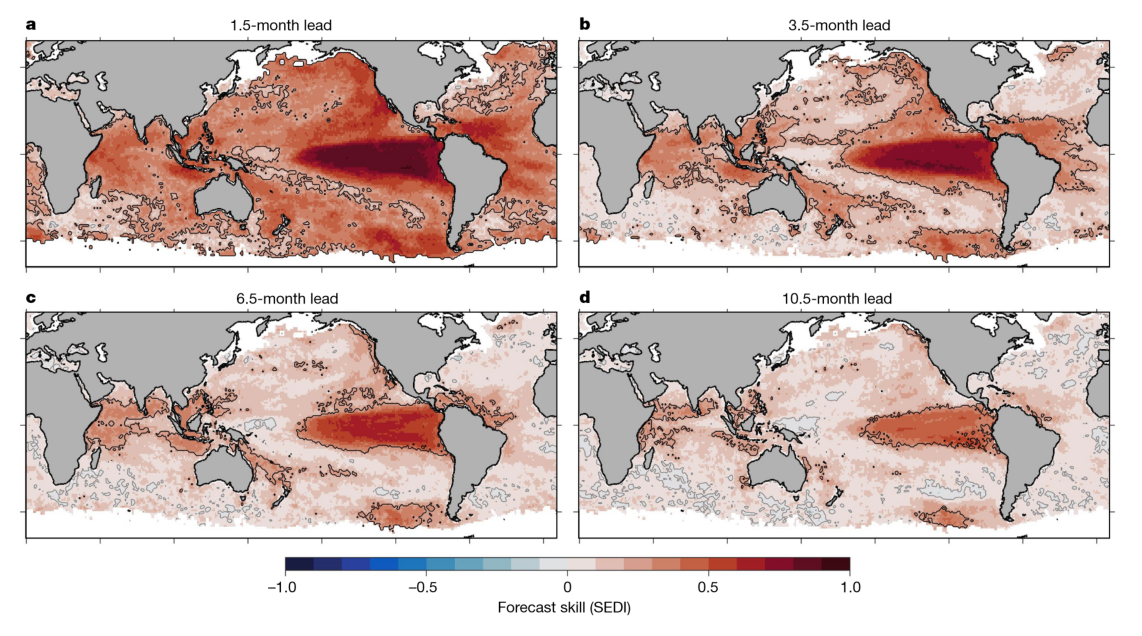

In [24]:
# Display Jacox et al figure for compoarison:
im1=plt.imread('JacoxSediByLead.png')
fig,ax=plt.subplots(1,1,figsize=(18,8))
im = ax.imshow(im1)
ax.axis('off')